## Modeling the Worst: A Zombie and Ebola outbreak

#### MOD300: Mandatory Project 2

#### Collaborators:  

Abstract

Introduction

#Modeling a Zombie Outbreak - SZ Model

**Aim.** Develop and document the two-compartment SZ model used in the project:
susceptibles S(t) and zombies Z(t). Provide (i) assumptions, (ii) derivation of the ODEs,
(iii) interpretation of β, (iv) the closed-form (analytic) solution, and (v) a short
sanity-check plot. This section is self-contained and stops before Exercise 1.

**Context.** The project specifies a minimal two-compartment model with only one flow:
S → Z. No curing or removal is included here. The population is assumed well-mixed
(mass-action).


#### 1) Model and Assumptions

**Compartments.** $S(t)$: susceptible humans; $Z(t)$: zombies. Only $S\to Z$ transport is allowed
(once bitten/scratched, you are a zombie). The compartments are assumed *well mixed*, i.e.,
pairs of individuals interact with equal probability.

**Contact model and infection probability.** Let $C(N)$ be the per-person contact rate
(contacts per unit time). At time $t$ the probability that a random contact is with a zombie
is $Z(t)/N$. Let $p_Z$ be the probability that an $S$–$Z$ encounter causes infection. Then define
the transmission parameter

$$
\beta \;=\; p_Z \cdot C(N) \quad \text{(units: time}^{-1}\text{).}
$$

Over a small interval $\Delta t$, the expected reduction in $S$ is
$$
S(t+\Delta t) - S(t) \;=\; -\,\beta\,\Delta t\,\frac{Z(t)}{N}\,S(t). \tag{1}
$$

**Constant population.** In this base model, $N = S(t) + Z(t)$ is treated as constant
(ignoring births/deaths/migration). Taking $\Delta t \to 0$ gives the ODE system
$$
\frac{dS}{dt} \;=\; -\beta \,\frac{S Z}{N},
\qquad
\frac{dZ}{dt} \;=\; \beta \,\frac{S Z}{N}. \tag{2–3}
$$

We assume $Z(0)=Z_0\ge 1$ (typically $Z_0=1$).



#### 2) Interpretation of $\beta$ — Technical and Intuitive Views

**Technical.** $\beta$ bundles (i) how often people meet ($C$) and (ii) how risky each $S$–$Z$
contact is ($p_Z$). The mass-action term $S\cdot Z/N$ encodes well-mixed interactions.
Equation (1) becomes (2–3) by dividing by $\Delta t$ and letting $\Delta t\to 0$.

**Intuition.** $\beta$ is a single “speed knob” for spread: more meetings and/or higher bite
risk $\Rightarrow$ faster conversion of $S$ to $Z$.


#### 3) Analytic (Closed-Form) Solution

With $S_0=S(0)$, $Z_0=Z(0)$, and $N=S_0+Z_0$, the SZ system (2–3) has the exact solution
$$
S(t)=\frac{(S_0+Z_0)\,(S_0/Z_0)\,e^{-\beta t}}{1+(S_0/Z_0)\,e^{-\beta t}},
\qquad
Z(t)=\frac{S_0+Z_0}{1+(S_0/Z_0)\,e^{-\beta t}}. \tag{4–5}
$$

These expressions conserve $S(t)+Z(t)=N$ for all $t$.

*Remark.* Using $S=N-Z$, (3) becomes $\,\dfrac{dZ}{dt}=\dfrac{\beta}{N}\,Z\,(N-Z)$, i.e., **logistic
growth** toward the carrying capacity $N$ when $\beta>0$ and $Z_0>0$ (formal fixed-point
analysis is left for Exercise 1).



#### 4) Parameter Example from the Project

A scenario in the project estimates $\beta$ with 10 hours of contact, a 20% infection chance
for the family, and one zombie among three persons ($Z/N=1/3$). Using
$$
\beta \cdot (Z/N) \cdot \Delta t \;=\; 0.20
\;\Rightarrow\;
\beta \cdot \frac{1}{3} \cdot 10\,\text{h} \;=\; 0.20
\;\Rightarrow\;
\beta \;=\; 0.06\ \text{h}^{-1}.
$$

We reuse $\beta=0.06\ \text{h}^{-1}$ in the demo below.


#### 5) Implementation (Utilities for Reuse Later)

We provide: (i) `beta_from_contacts` to compute $\beta = p_{\text{infect}}\cdot\text{contact\_rate}$,
(ii) `analytic_sz` to evaluate the exact solution at arbitrary times, and (iii) a
conservation checker for $S+Z=N$. These will be reused to validate numerical solvers
in later parts of the project.


In [68]:
#%% 
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple

def beta_from_contacts(p_infect: float, contacts_per_person_per_time: float) -> float:
    """
    Compute β = p_infect * contacts_per_person_per_time.

    Parameters
    ----------
    p_infect : float
        Probability that an S–Z encounter infects the human (0..1).
    contacts_per_person_per_time : float
        Average per-person contact rate (per unit time).

    Returns
    -------
    float
        β in 1/time units.
    """
    return p_infect * contacts_per_person_per_time


def analytic_sz(t: np.ndarray, S0: float, Z0: float, beta: float) -> Tuple[np.ndarray, np.ndarray]:
    """
    Closed-form (analytic) SZ solution.

    Parameters
    ----------
    t : array-like
        Time points for evaluation.
    S0 : float
        Initial susceptible count at t=0.
    Z0 : float
        Initial zombie count at t=0 (>= 1 for nontrivial dynamics).
    beta : float
        Transmission parameter (1/time).

    Returns
    -------
    (S, Z) : tuple of np.ndarray
        Arrays of S(t) and Z(t) at the requested times.

    Notes
    -----
    Implements equations (4)–(5) with N = S0 + Z0.
    """
    t = np.asarray(t, dtype=float)
    N = S0 + Z0
    ratio = (S0 / Z0) * np.exp(-beta * t)
    denom = (1.0 + ratio)
    S = (N * (S0 / Z0) * np.exp(-beta * t)) / denom
    Z = N / denom
    return S, Z


def check_conservation(S: np.ndarray, Z: np.ndarray, N: float, atol: float = 1e-10) -> bool:
    """Return True if S+Z == N within the given tolerance."""
    return np.allclose(S + Z, N, atol=atol)


#### 6) Sanity-Check Demo (Not Exercise 1)

We take $N=1000$, $Z_0=1$, $S_0=999$, and $\beta=0.06\ \text{h}^{-1}$ (from the scenario),
evaluate the analytic solution on $[0,200]$ hours, verify conservation, and plot fractions
$S/N$ and $Z/N$. This is *only* to visualize the model’s qualitative behavior; Exercise 1
will use the same formulas to compare Sokndal and Dirdal explicitly.


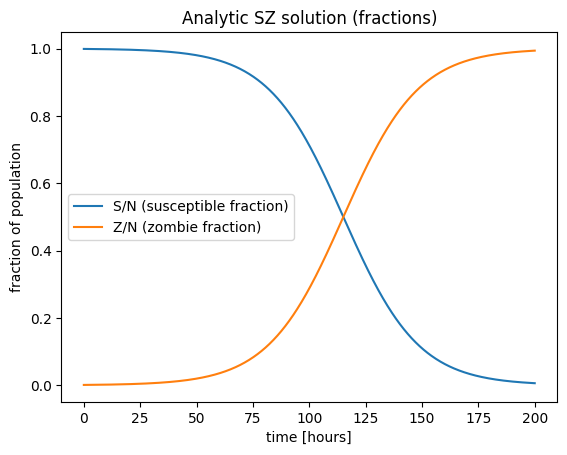

In [69]:
#%% 
# Parameters
N = 1000.0
Z0 = 1.0
S0 = N - Z0
beta = 0.06  # h^-1 (from the scenario)

# Time grid (hours)
t = np.linspace(0.0, 200.0, 800)

# Analytic solution
S, Z = analytic_sz(t, S0, Z0, beta)

# Conservation check
assert check_conservation(S, Z, N), "Conservation failed: S+Z != N"

# (Optional) monotonicity sanity check for β>0, Z0>0:
dS = np.diff(S)
dZ = np.diff(Z)
assert (dS <= 1e-12).all(), "S(t) should be non-increasing for β>0, Z0>0"
assert (dZ >= -1e-12).all(), "Z(t) should be non-decreasing for β>0, Z0>0"

# Plot fractions
plt.figure()
plt.plot(t, S / N, label="S/N (susceptible fraction)")
plt.plot(t, Z / N, label="Z/N (zombie fraction)")
plt.xlabel("time [hours]")
plt.ylabel("fraction of population")
plt.title("Analytic SZ solution (fractions)")
plt.legend()
plt.show()



## 7) Summary of the SZ Section

- The base model assumes well-mixed interactions and a single S→Z flow; \(N=S+Z\) is constant.
- The governing equations are \(dS/dt = -\beta S Z / N\) and \(dZ/dt = \beta S Z / N\), with \(\beta=p_Z\cdot C(N)\).
- The analytic solution (4–5) conserves population and is ideal for validating numerical solvers.
- A project-provided scenario gives \(\beta = 0.06\ \text{h}^{-1}\); we used it for a minimal sanity check.

**Next step (Exercise 1, not done here):** use (4–5) to compare zombie fractions for Sokndal (N=3305)
and Dirdal (N=683), and analyze critical points/logistic limit behavior for \(\beta>0\).


### Exercise 1 — No hope?

We compare the **fraction of the population turned into zombies** in **Sokndal** and **Dirdal**
using the **analytic SZ solution**, then find the **critical points** and explain why humanity
is eradicated as $t \to \infty$ for any $\beta>0$.

Data: Dirdal has $N=683$ inhabitants; Sokndal has $N=3305$. From the "family exposure"
scenario (10 hours, 20% chance, one zombie among three people) we get
$$
\beta \cdot \frac{Z}{N} \cdot \Delta t = 0.20
\;\Rightarrow\; \beta \cdot \frac{1}{3} \cdot 10\ \mathrm{h} = 0.20
\;\Rightarrow\; \beta = 0.06\ \mathrm{h}^{-1}.
$$

We take $Z_0=1$ and $S_0=N-1$ for both towns.



#### Analytic SZ solution reminder

With $S_0=S(0)$, $Z_0=Z(0)$, and $N=S_0+Z_0$, the exact solution is
$$
S(t) = \frac{(S_0+Z_0)\,(S_0/Z_0)\,e^{-\beta t}}{1 + (S_0/Z_0)\,e^{-\beta t}},\qquad
Z(t) = \frac{S_0+Z_0}{1 + (S_0/Z_0)\,e^{-\beta t}}.
$$

Hence the **zombie fraction** is
$$
\frac{Z(t)}{N} = \frac{1}{1 + (S_0/Z_0)\,e^{-\beta t}}
= \frac{1}{1 + (N-1)\,e^{-\beta t}}\quad\text{when } Z_0=1.
$$

These satisfy $S(t)+Z(t)=N$ for all $t$.



#### Task 1 — Plot and compare zombie fractions (Sokndal vs Dirdal)

Technical: We plot $Z(t)/N$ using the analytic formula with
$(N,\beta,Z_0)=(3305,0.06,1)$ for Sokndal and $(683,0.06,1)$ for Dirdal.
Because the initial fraction $z_0=Z_0/N$ is larger in Dirdal, its curve is
ahead initially, but both tend to 1.

Start with 1 zombie in each town. In the smaller town (Dirdal),
that one zombie is a bigger share of people, so it tips faster at first.
Eventually both towns get overrun.


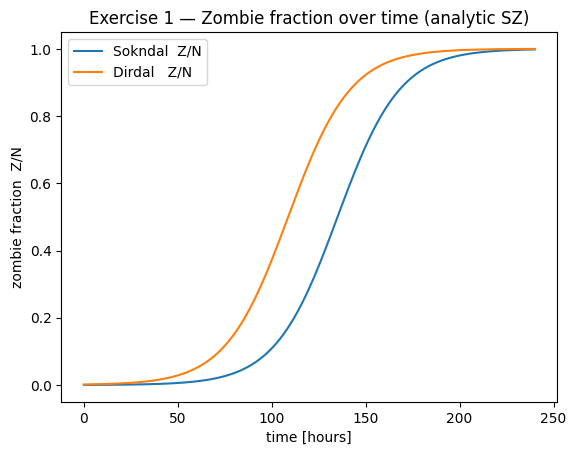

In [70]:
#%% 
import numpy as np
import matplotlib.pyplot as plt

# Analytic zombie fraction (self-contained utility)
def z_fraction(t, N, beta, Z0=1.0):
    S0 = N - Z0
    return 1.0 / (1.0 + (S0 / Z0) * np.exp(-beta * t))

# Parameters
beta = 0.06  # per hour
N_sokndal = 3305.0
N_dirdal  =  683.0
Z0 = 1.0

# Time grid (hours)
t = np.linspace(0.0, 240.0, 800)  # ~10 days; adjust if needed

# Fractions
z_frac_sok = z_fraction(t, N_sokndal, beta, Z0)
z_frac_dir = z_fraction(t, N_dirdal,  beta, Z0)

# Plot
plt.figure()
plt.plot(t, z_frac_sok, label="Sokndal  Z/N")
plt.plot(t, z_frac_dir, label="Dirdal   Z/N")
plt.xlabel("time [hours]")
plt.ylabel("zombie fraction  Z/N")
plt.title("Exercise 1 — Zombie fraction over time (analytic SZ)")
plt.legend()
plt.show()



#### Optional: time to 50 percent zombies

Solve $Z(t)/N = 1/2$:

From $\frac{1}{1+(S_0/Z_0)e^{-\beta t}} = \frac{1}{2}$ we get
$$
t_{50} = \frac{1}{\beta}\,\ln\!\Big(\frac{S_0}{Z_0}\Big).
$$

With $Z_0=1$:
- Sokndal: $t_{50} = (1/0.06)\,\ln(3304) \approx 135\ \mathrm{h}$ (about 5.6 days).
- Dirdal:  $t_{50} = (1/0.06)\,\ln(682)  \approx 109\ \mathrm{h}$ (about 4.5 days).

Interpretation: Dirdal hits 50% sooner because $1/N$ is larger, but both go to 100%.



#### Task 2 — Critical points and why humanity is doomed

Starting SZ equations:
$$
\frac{dS}{dt} = -\beta\,\frac{S Z}{N},\qquad
\frac{dZ}{dt} =  \beta\,\frac{S Z}{N}.
$$

Use $S=N-Z$ to get a single equation for $Z(t)$:
$$
\frac{dZ}{dt} = \frac{\beta}{N}\,Z\,(N-Z),
$$
which is the **logistic equation** with equilibria at $Z^*=0$ and $Z^*=N$.

Linearization via derivative:
$$
\frac{d}{dZ}\Big(\frac{dZ}{dt}\Big) = \frac{\beta}{N}\,(N - 2Z).
$$

- At $Z^*=0$: derivative $= \beta > 0$ so it is **unstable** (any $Z_0>0$ grows).
- At $Z^*=N$: derivative $= -\beta < 0$ so it is **stable**.

Conclusion: For any $\beta>0$ and any $Z_0>0$,
$$
Z(t)\to N \quad\text{and}\quad S(t)\to 0 \quad \text{as } t\to\infty,
$$
so under SZ assumptions there is **no hope**: humans are eventually all zombified.



#### Exercise 1 — Short Summary

- **Goal:** Compare the zombie fraction $Z(t)/N$ for **Sokndal ($N=3305$)** and **Dirdal ($N=683$)** using the analytic SZ model, and state the long-term outcome.
- **Setup:** One initial zombie in each town ($Z_0=1$, $S_0=N-1$). Early-phase parameter from the scenario: $\beta = 0.06\ \mathrm{h}^{-1}$.
- **Analytic result used:** $Z(t)/N = \dfrac{1}{1 + (S_0/Z_0)\,e^{-\beta t}}$. With $Z_0=1$: $Z(t)/N = \dfrac{1}{1 + (N-1)\,e^{-\beta t}}$.
- **Finding (plot):** Dirdal’s curve rises faster initially (larger $Z_0/N$ in a smaller population), but **both towns approach $Z/N \to 1$**.
- **Why “no hope”:** From $\dot S = -\beta (S Z / N)$, $\dot Z = \beta (S Z / N)$ and $S=N-Z$, we get the logistic equation $\dot Z = (\beta/N)\,Z\,(N-Z)$. Equilibria: $Z^*=0$ (unstable) and $Z^*=N$ (stable). For any $\beta>0$ and $Z_0>0$: $Z(t)\to N$ and $S(t)\to 0$.



### Exercise 2 — Numerical solver implementation (Intro)

**Goal.** Build a reusable numerical ODE solver for systems in the form
$$ \frac{dy}{dt} = f(y,t), $$
and use it on the SZ model with $y=(S,Z)$ and
$$ f(y,t) = \big(-\beta\,S Z/N,\ \beta\,S Z/N\big). $$
Then: (i) **verify** against the analytic SZ solution (Exercise 1), and (ii) **experiment** with the time step $\Delta t$. :contentReference[oaicite:0]{index=0}

**What I implement.** A small, general solver supporting **Forward Euler** and **Runge–Kutta 4** (fixed step), plus utilities for errors and plots. I test with $\beta=0.06\ \mathrm{h}^{-1}$ (from the assignment’s estimate) and $Z_0=1$, $S_0=N-1$. :contentReference[oaicite:1]{index=1}



#### 1) Model recap and analytic reference

The SZ model uses
$$
\dot S = -\beta\,\frac{S Z}{N},\qquad
\dot Z = \beta\,\frac{S Z}{N},\qquad N=S+Z\ \text{(constant)}.
$$
The **analytic solution** with $S_0=S(0)$, $Z_0=Z(0)$, $N=S_0+Z_0$ is
$$
S(t)=\frac{(S_0+Z_0)\,(S_0/Z_0)\,e^{-\beta t}}{1+(S_0/Z_0)\,e^{-\beta t}},\qquad
Z(t)=\frac{S_0+Z_0}{1+(S_0/Z_0)\,e^{-\beta t}}.
$$
I will use this to compute **truth** for error checks. :contentReference[oaicite:2]{index=2}


In [71]:
#%% 
# 2) Reusable analytic SZ and helpers

import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Tuple, Dict

def sz_analytic(t: np.ndarray, S0: float, Z0: float, beta: float) -> Tuple[np.ndarray, np.ndarray]:
    """Analytic SZ solution; returns arrays S(t), Z(t)."""
    t = np.asarray(t, dtype=float)
    N = S0 + Z0
    ratio = (S0 / Z0) * np.exp(-beta * t)
    denom = 1.0 + ratio
    S = (N * (S0 / Z0) * np.exp(-beta * t)) / denom
    Z = N / denom
    return S, Z

def check_conservation(S: np.ndarray, Z: np.ndarray, N: float, atol: float = 1e-10) -> bool:
    return np.allclose(S + Z, N, atol=atol)



#### 3) General-purpose ODE solver (Forward Euler, RK4)

We target the general system $y' = f(y,t)$ with **fixed step** $\Delta t$.  
- **Forward Euler (FE):** $y_{n+1} = y_n + \Delta t\,f(y_n,t_n)$ (first order).  
- **RK4:** classical 4th order method.  

The API is solver-agnostic: pass any `f(t, y, params)` and `y0`. :contentReference[oaicite:3]{index=3}


In [72]:
#%% 
Array = np.ndarray

class ODESolver:
    def __init__(self, f: Callable[[float, Array, Dict], Array]):
        """
        f: callable f(t, y, params) -> array_like with same shape as y
        """
        self.f = f

    @staticmethod
    def _as_array(y0) -> Array:
        y0 = np.asarray(y0, dtype=float)
        return y0.copy()

    def solve(
        self,
        t0: float,
        t_end: float,
        dt: float,
        y0,
        params: Dict,
        method: str = "rk4",
    ) -> Tuple[Array, Array]:
        """
        Integrate y' = f(t, y, params) from t0 to t_end with fixed step dt.

        Returns
        -------
        t : (m,) array of time points
        Y : (m, d) array with state at each time (rows are time, columns are components)
        """
        assert dt > 0.0 and t_end > t0
        method = method.lower()
        y = self._as_array(y0)
        d = y.size

        # preallocate a bit conservatively; then trim
        m = int(np.ceil((t_end - t0) / dt)) + 1
        t = np.empty(m, dtype=float)
        Y = np.empty((m, d), dtype=float)

        tn = t0
        idx = 0
        t[idx] = tn
        Y[idx] = y

        while tn < t_end - 1e-14:
            h = min(dt, t_end - tn)

            if method == "euler":
                k1 = self.f(tn, y, params)
                y = y + h * k1
            elif method == "rk4":
                k1 = self.f(tn, y, params)
                k2 = self.f(tn + 0.5*h, y + 0.5*h*k1, params)
                k3 = self.f(tn + 0.5*h, y + 0.5*h*k2, params)
                k4 = self.f(tn + h,     y + h*k3,     params)
                y = y + (h/6.0)*(k1 + 2*k2 + 2*k3 + k4)
            else:
                raise ValueError(f"Unknown method: {method}")

            tn = tn + h
            idx += 1
            t[idx] = tn
            Y[idx] = y

        # trim arrays to actual length
        t = t[: idx + 1]
        Y = Y[: idx + 1]
        return t, Y



#### 4) Apply the solver to SZ (constant $\beta$) and validate vs analytic

Set $N$, $S_0$, $Z_0$, $\beta$, integrate on a time grid, and compare with the analytic
solution from above. The assignment’s early-phase estimate is $\beta=0.06\ \mathrm{h}^{-1}$. :contentReference[oaicite:4]{index=4}


In [73]:
#%% 
# Problem setup (same as Exercise 1 baseline)
beta = 0.06  # h^-1
N = 1000.0
Z0 = 1.0
S0 = N - Z0

# Right-hand side for SZ: y = [S, Z]
def sz_rhs(t: float, y: Array, params: Dict) -> Array:
    S, Z = y
    beta = params["beta"]
    N = params["N"]
    dS = -beta * S * Z / N
    dZ =  beta * S * Z / N
    return np.array([dS, dZ])

solver = ODESolver(f=sz_rhs)

# Integrate with RK4
t0, t_end, dt = 0.0, 200.0, 0.25  # hours
params = {"beta": beta, "N": N}
t_rk4, Y_rk4 = solver.solve(t0, t_end, dt, y0=[S0, Z0], params=params, method="rk4")
S_rk4, Z_rk4 = Y_rk4[:,0], Y_rk4[:,1]

# Analytic reference on the *same* times
S_ref, Z_ref = sz_analytic(t_rk4, S0, Z0, beta)

# Checks
assert check_conservation(S_rk4, Z_rk4, N), "Conservation failed numerically (S+Z != N)."

# Errors
err_S = np.abs(S_rk4 - S_ref)
err_Z = np.abs(Z_rk4 - Z_ref)
max_err_S = np.max(err_S)
max_err_Z = np.max(err_Z)
max_err_S, max_err_Z


(np.float64(5.035647063778015e-07), np.float64(5.035633989791677e-07))


#### 5) Plots: numeric vs analytic, and absolute errors

The first plot overlays $S/N$ and $Z/N$ (RK4 vs analytic). The second plot shows absolute
errors $|S_{\text{num}}-S|$, $|Z_{\text{num}}-Z|$ over time.


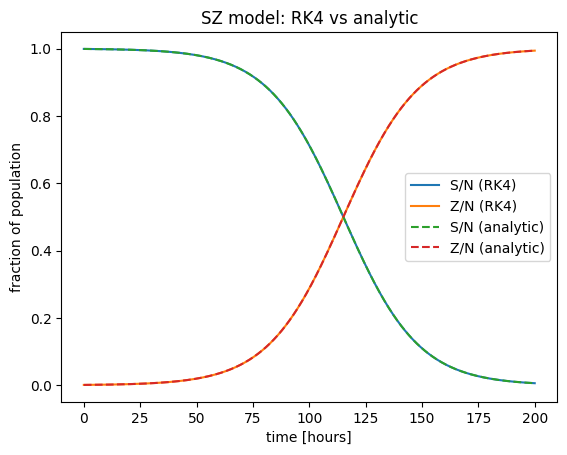

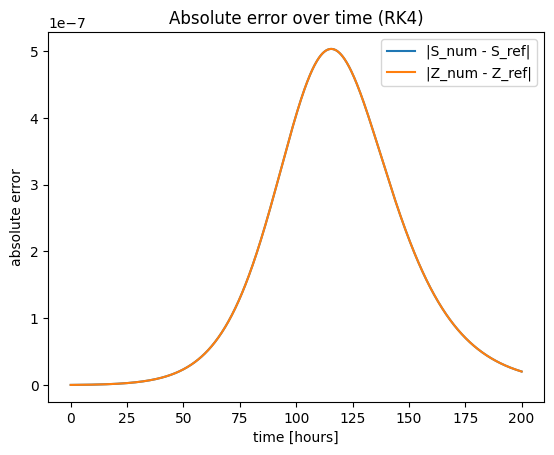

In [74]:
#%% 
# Overlay of solutions (fractions)
plt.figure()
plt.plot(t_rk4, S_rk4 / N, label="S/N (RK4)")
plt.plot(t_rk4, Z_rk4 / N, label="Z/N (RK4)")
plt.plot(t_rk4, S_ref / N, label="S/N (analytic)", linestyle="--")
plt.plot(t_rk4, Z_ref / N, label="Z/N (analytic)", linestyle="--")
plt.xlabel("time [hours]")
plt.ylabel("fraction of population")
plt.title("SZ model: RK4 vs analytic")
plt.legend()
plt.show()

# Absolute errors
plt.figure()
plt.plot(t_rk4, err_S, label="|S_num - S_ref|")
plt.plot(t_rk4, err_Z, label="|Z_num - Z_ref|")
plt.xlabel("time [hours]")
plt.ylabel("absolute error")
plt.title("Absolute error over time (RK4)")
plt.legend()
plt.show()



#### 6) Step-size experiment (order and stability)

**What to do.** Solve with a sequence of $\Delta t$ values and measure a scalar error
(e.g. max-norm of $Z$ error). Expect:
- **Euler:** first order, error $\propto \Delta t$; may become unstable for too large $\Delta t$.
- **RK4:** fourth order, error $\propto \Delta t^4$; much more accurate at the same step.

The assignment explicitly asks you to “make $\Delta t$ progressively larger” and comment on
what you observe. :contentReference[oaicite:5]{index=5}


In [75]:
#%% 
def max_err_vs_dt(method: str, dts, t_end=200.0):
    errs = []
    for dt in dts:
        t_num, Y_num = solver.solve(0.0, t_end, dt, y0=[S0, Z0], params=params, method=method)
        S_num, Z_num = Y_num[:,0], Y_num[:,1]
        # compare against analytic on same time points
        S_ref, Z_ref = sz_analytic(t_num, S0, Z0, beta)
        errs.append(np.max(np.abs(Z_num - Z_ref)))
    return np.array(errs)

dts = np.array([2.0, 1.0, 0.5, 0.25, 0.125])  # hours
e_euler = max_err_vs_dt("euler", dts)
e_rk4   = max_err_vs_dt("rk4",   dts)

# Print a small "convergence" table and empirical orders
orders_euler = np.log2(e_euler[:-1] / e_euler[1:])
orders_rk4   = np.log2(e_rk4[:-1]   / e_rk4[1:])
list(zip(dts, e_euler, e_rk4)), orders_euler, orders_rk4


([(np.float64(2.0),
   np.float64(81.42912318233675),
   np.float64(0.0019047057323859917)),
  (np.float64(1.0),
   np.float64(41.09281321627117),
   np.float64(0.00012456775141345133)),
  (np.float64(0.5),
   np.float64(20.63209506851058),
   np.float64(7.965855218117213e-06)),
  (np.float64(0.25),
   np.float64(10.335816012411726),
   np.float64(5.035633989791677e-07)),
  (np.float64(0.125),
   np.float64(5.172645297245879),
   np.float64(3.1652689358452335e-08))],
 array([0.98665877, 0.99399577, 0.99723803, 0.99867812]),
 array([3.93456559, 3.96695756, 3.98358393, 3.99177344]))


#### 7) Visualize error vs step size

On a log–log plot, slopes near 1 (Euler) and near 4 (RK4) confirm the expected orders.


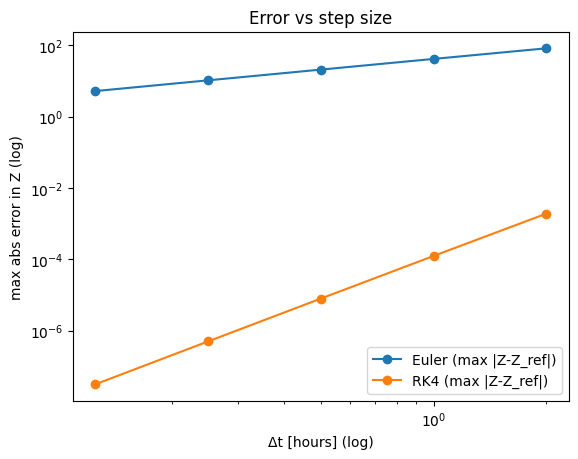

In [76]:
#%% 
plt.figure()
plt.loglog(dts, e_euler, marker="o", label="Euler (max |Z-Z_ref|)")
plt.loglog(dts, e_rk4, marker="o", label="RK4 (max |Z-Z_ref|)")
plt.xlabel("Δt [hours] (log)")
plt.ylabel("max abs error in Z (log)")
plt.title("Error vs step size")
plt.legend()
plt.show()



#### 8) (Optional) When Euler goes unstable

Try very large steps (e.g., $\Delta t=6$–$12$ hours). Euler may overshoot and even produce
non-physical negative $S$ or $Z$. RK4 will tolerate larger steps but will also fail if $\Delta t$
is extreme (it is still an explicit fixed-step method).


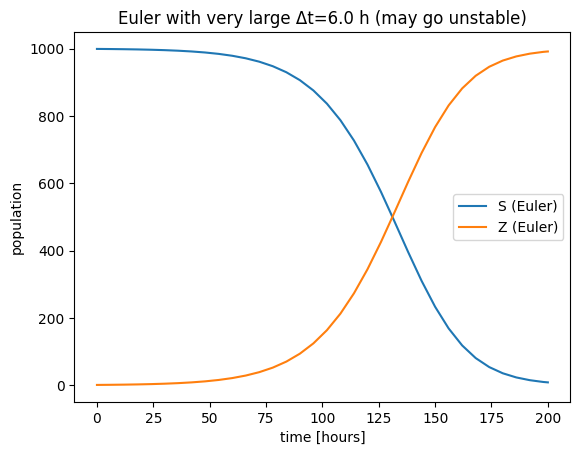

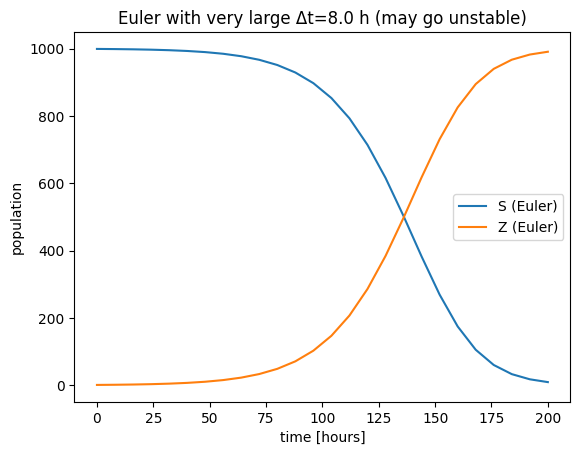

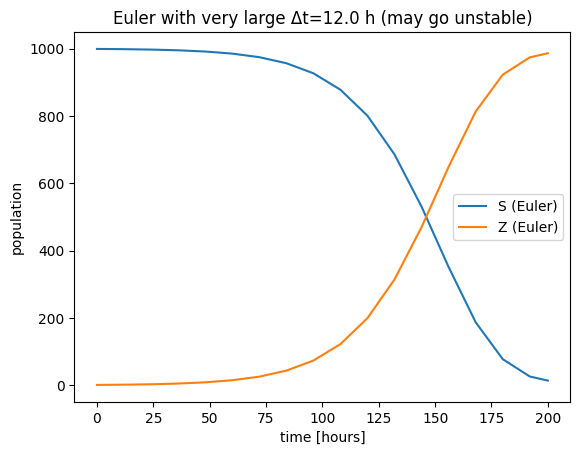

In [77]:
#%% 
# OPTIONAL: uncomment to try very large Δt
for dt_bad in [6.0, 8.0, 12.0]:
     t_bad, Y_bad = solver.solve(0.0, 200.0, dt_bad, y0=[S0, Z0], params=params, method="euler")
     plt.figure()
     plt.plot(t_bad, Y_bad[:,0], label="S (Euler)")
     plt.plot(t_bad, Y_bad[:,1], label="Z (Euler)")
     plt.xlabel("time [hours]")
     plt.ylabel("population")
     plt.title(f"Euler with very large Δt={dt_bad} h (may go unstable)")
     plt.legend()
     plt.show()



####  Summary

- I implemented a **general ODE solver** with **Forward Euler** and **RK4** for $y' = f(y,t)$. :contentReference[oaicite:6]{index=6}  
- Using the SZ system and the assignment’s $\beta=0.06\ \mathrm{h}^{-1}$, the RK4 solution matches the **analytic** solution closely; conservation $S+Z=N$ holds numerically for small $\Delta t$.   
- **Step-size effects:** Euler shows first-order convergence and can become **unstable** for large $\Delta t$; RK4 exhibits fourth-order convergence and remains accurate for much larger $\Delta t$, but will also degrade if $\Delta t$ is too coarse. :contentReference[oaicite:8]{index=8}


## Exercise 3: Predicting the fate of Sokndal and Dirdal

Zombie-infection rate is now assumed to be time dependent and decline exponentially.


### Task 3.1

Estimate the decay rate ($\lambda$) from the provided information regarding the Sokndal and Dirdal outbreaks.

From the equations provided (10), (11) and (12), we have this:

$e^{-\lambda T} = 0.6 \implies \lambda = -\frac{1}{T} \ln(0.6)$

#### Plug in values:
**Sokndal:** T = 48 hours. 

$\lambda_{\text{Sokndal}} = -\frac{1}{48} \ln 0.6$,

**Dirdal:** T = 72 hours.

$\lambda_{\text{Dirdal}} = -\frac{1}{72} \ln 0.6$


**Computing these numerically:**

In [78]:
import numpy as np

alpha_sokndal = -np.log(0.6)/48
alpha_dirdal = -np.log(0.6)/72
print(alpha_sokndal, alpha_dirdal)

0.010642200495124807 0.007094800330083205


### Task 3.2
Solving the SZ-model numerically, but now the $\beta$-factor is time dependent.

Exercise 4

Exercise 5

Reflection